<h1><center> Capstone Project </center></h1>

##### Capstone project guided by Coursera. All subprojects are given in one notebook.

In [67]:
import pandas as pd
import numpy as np

print('Hello Capstone Project Course')

Hello Capstone Project Course


# Part 1. Clustering neighborhoods in Toronto

In [151]:
# Private information, which will be used in this notebook

key = ' ???? '  # Google Geocoder API key
CLIENT_ID = ' ???? ' # my Foursquare ID
CLIENT_SECRET = ' ???? ' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value




##
### Task 1. Create Dataframe.
##

In [38]:
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import requests

In [47]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
raw_data = requests.get(url).text
soup = bs(raw_data, 'html5lib')

In [64]:

table_contents=[]
table=soup.find('table')

for row in table.findAll('td'):
    cell = {}
    if (row.span.text=='Not assigned'):
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
        
df = pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

df.dropna(how = 'any', inplace = True)
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [62]:

df.shape

(103, 3)

##
### Task 2. Getting locations data.
##
Note!  

Please, be kindly informed that because I am using Google API and not Python Geocoder
package, I can collect more precise locations for every neighbor even with the
same Postal Code. So probably my dataframe final shape can be longer than for those who
are using Python Geocoder. 

In [108]:
#    I am using Google Geocoding Api, but I need to hide my API key for privacy reasons


import googlemaps


gmaps = googlemaps.Client(key=key)



df_with_coord = {'index':[], 'pc':[], 'borough':[], 'neighborhood':[], 'lat':[], 'long':[]}  

index = 0  # for being sure that neighbors with the same Postal Code will not collapse, 
           # indexing will be used

for hood, borough, pc in zip(df.Neighborhood, df.Borough, df.PostalCode):
    
    # Firstly, care about hoods with two or more names per row
    
    if ',' in hood:
        hood_splitted = hood.split(',')
        for name in hood_splitted:
            
            index += 1
            
            # for every name find location, using Geocodong API
            
            location_str = f'{name}, {borough}'
            geocode_result = gmaps.geocode(location_str)
            lat = geocode_result[0]['geometry']['location']['lat']
            long = geocode_result[0]['geometry']['location']['lng']
            
            # update dict
            
            df_with_coord['index'].append(index)
            df_with_coord['pc'].append(pc)
            df_with_coord['borough'].append(borough)
            df_with_coord['neighborhood'].append(name)
            df_with_coord['lat'].append(lat)
            df_with_coord['long'].append(long)
            
    else:
        
        index += 1
            
        # for every hood find location, using Geocodong API

        location_str = f'{hood}, {borough}'
        geocode_result = gmaps.geocode(location_str)
        lat = geocode_result[0]['geometry']['location']['lat']
        long = geocode_result[0]['geometry']['location']['lng']

        # update dict

        df_with_coord['index'].append(index)
        df_with_coord['pc'].append(pc)
        df_with_coord['borough'].append(borough)
        df_with_coord['neighborhood'].append(hood)
        df_with_coord['lat'].append(lat)
        df_with_coord['long'].append(long)






In [111]:
# Creating final dataframe from dictionary with latitudes and longitudes

final_data = pd.DataFrame(df_with_coord)
final_data.drop('index', axis = 1, inplace = True)
final_data.columns = ['Postal_Code', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']
final_data.head()


,Postal_Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.752777,-79.326440
1,M4A,North York,Victoria Village,43.735735,-79.312418
2,M5A,Downtown Toronto,Regent Park,43.660323,-79.362044
3,M5A,Downtown Toronto,Harbourfront,43.640552,-79.378937
4,M6A,North York,Lawrence Manor,43.725924,-79.436320


##
### Task 3. Clustering the neighborhoods of one borough. 
##

In [145]:
#   I want to find borough with highest number of neighborhoods and use it
# for analysis

boroughs = list(final_data.Borough.unique())
length = []

for i in range(len(boroughs)):
    length.append(len(final_data[(final_data.Borough == boroughs[i])]))
    
index_of_search = length.index(max(length))


if length.count(max(length)) > 1:
    print(f'There are {length.count(max(length))} Boroughs with max number of neighborhoods')
else:
    print (f'We will use this borough with highest number of neighborhoods: \n {boroughs[index_of_search]}')

    

We will use this borough with highest number of neighborhoods: 
 Etobicoke


In [150]:
data_etobicoke = final_data[(final_data.Borough == 'Etobicoke')].reset_index(drop=True)
data_etobicoke.head()


,Postal_Code,Borough,Neighborhood,Latitude,Longitude
0,M9A,Etobicoke,Islington Avenue,43.682778,-79.540297
1,M9B,Etobicoke,West Deane Park,43.664367,-79.563172
2,M9B,Etobicoke,Princess Gardens,43.670050,-79.547744
3,M9B,Etobicoke,Martin Grove,43.701951,-79.575692
4,M9B,Etobicoke,Islington,43.630916,-79.543484


In [161]:
# function that finds nearby venues

    
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

etobicoke_venues = getNearbyVenues(data_etobicoke.Neighborhood, data_etobicoke.Latitude, 
                                   data_etobicoke.Longitude, radius=500)



In [162]:
# Venues dataframe

print(etobicoke_venues.shape)
etobicoke_venues.head()

(388, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Islington Avenue,43.682778,-79.540297,Silvercreek Park,43.684095,-79.540633,Park
1,Islington Avenue,43.682778,-79.540297,Apple Movers,43.683686,-79.537690,Moving Target
2,Islington Avenue,43.682778,-79.540297,Islington & Eglinton,43.680201,-79.539804,Intersection
3,Islington Avenue,43.682778,-79.540297,Westway Park,43.685528,-79.541434,Baseball Field
4,Islington Avenue,43.682778,-79.540297,CleanBite,43.681563,-79.534401,Food Service


####
##### Let's check how many venues were returned for each neighborhood
####

In [163]:
etobicoke_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Albion Gardens,5,5,5,5,5,5
Beaumond Heights,10,10,10,10,10,10
Bloordale Gardens,8,8,8,8,8,8
Cloverdale,20,20,20,20,20,20
Humber Bay,19,19,19,19,19,19
Humber Bay Shores,15,15,15,15,15,15
Humbergate,1,1,1,1,1,1
Islington,7,7,7,7,7,7
Jamestown,3,3,3,3,3,3


####
##### Let's find out how many unique categories can be curated from all the returned venues
####

In [164]:
print('There are {} uniques categories.'.format(len(etobicoke_venues['Venue Category'].unique())))

There are 97 uniques categories.


###
#### Neighborhood analysis
###


In [165]:
# one hot encoding
etobicoke_onehot = pd.get_dummies(etobicoke_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
etobicoke_onehot['Neighborhood'] = etobicoke_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [etobicoke_onehot.columns[-1]] + list(etobicoke_onehot.columns[:-1])
etobicoke_onehot = etobicoke_onehot[fixed_columns]

etobicoke_onehot.head()

,Neighborhood,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Baseball Field,...,Spa,Sporting Goods Shop,Supermarket,Supplement Shop,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Thrift / Vintage Store,Vietnamese Restaurant,Yoga Studio
0,Islington Avenue,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Islington Avenue,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Islington Avenue,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Islington Avenue,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Islington Avenue,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [166]:
etobicoke_onehot.shape

(388, 98)

####
##### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
####

In [167]:
etobicoke_grouped = etobicoke_onehot.groupby('Neighborhood').mean().reset_index()
etobicoke_grouped

,Neighborhood,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Baseball Field,...,Spa,Sporting Goods Shop,Supermarket,Supplement Shop,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Thrift / Vintage Store,Vietnamese Restaurant,Yoga Studio
0,Albion Gardens,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.200000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
1,Beaumond Heights,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
2,Bloordale Gardens,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
3,Cloverdale,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.100000,0.05,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
4,Humber Bay,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00,0.052632,0.000000,0.00,0.000000,0.000000,0.000000
5,Humber Bay Shores,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.066667,0.0,...,0.066667,0.000000,0.000000,0.00,0.066667,0.000000,0.00,0.000000,0.000000,0.000000
6,Humbergate,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
7,Islington,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.142857,0.000000
8,Jamestown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
9,King's Mill Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000


####
##### New size:
####

In [170]:
etobicoke_grouped.shape

(44, 98)

####
##### Let's print each neighborhood along with the top 5 most common venues
####

In [171]:
num_top_venues = 5

for hood in etobicoke_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = etobicoke_grouped[etobicoke_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Albion Gardens----
                  venue  freq
0  Caribbean Restaurant   0.4
1      Asian Restaurant   0.2
2              Pharmacy   0.2
3           Supermarket   0.2
4   American Restaurant   0.0


---- Beaumond Heights----
                  venue  freq
0     Indian Restaurant   0.3
1  Caribbean Restaurant   0.2
2                  Bank   0.1
3           Pizza Place   0.1
4        Ice Cream Shop   0.1


---- Bloordale Gardens----
               venue  freq
0  Convenience Store  0.25
1      Deli / Bodega  0.12
2               Park  0.12
3        Coffee Shop  0.12
4     Sandwich Place  0.12


---- Cloverdale----
                  venue  freq
0  Fast Food Restaurant  0.10
1           Coffee Shop  0.10
2           Supermarket  0.10
3      Department Store  0.05
4           Gas Station  0.05


---- Humber Bay----
                venue  freq
0         Coffee Shop  0.16
1  Italian Restaurant  0.05
2       Smoothie Shop  0.05
3         Pizza Place  0.05
4      Farmers Market  0.05


---

####
##### Now we will put that into _pandas_ dataframe
####

In [172]:
# function for sorting the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


####
##### New dataframe with the top 10 venues for each neighborhood.
####

In [203]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = etobicoke_grouped['Neighborhood']

for ind in np.arange(etobicoke_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(etobicoke_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albion Gardens,Caribbean Restaurant,Asian Restaurant,Pharmacy,Supermarket,American Restaurant,Moving Target,Pool Hall,Plaza,Playground,Pizza Place
1,Beaumond Heights,Indian Restaurant,Caribbean Restaurant,Bank,Pizza Place,Ice Cream Shop,Coffee Shop,American Restaurant,Sushi Restaurant,Movie Theater,Playground
2,Bloordale Gardens,Convenience Store,Deli / Bodega,Park,Coffee Shop,Sandwich Place,Print Shop,Intersection,Light Rail Station,Liquor Store,Indie Movie Theater
3,Cloverdale,Fast Food Restaurant,Coffee Shop,Supermarket,Department Store,Gas Station,Pub,Record Shop,Discount Store,Pharmacy,Sandwich Place
4,Humber Bay,Coffee Shop,Italian Restaurant,Smoothie Shop,Pizza Place,Farmers Market,Fast Food Restaurant,Pharmacy,Sandwich Place,Chinese Restaurant,Pet Store


####
##### And finally, clustering
####

In [204]:
etobicoke_grouped_clustering.shape

(44, 97)

In [205]:
from sklearn.cluster import KMeans
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors


# set number of clusters
kclusters = 5

etobicoke_grouped_clustering = etobicoke_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(etobicoke_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 4, 2, 2, 2])

#####
Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

#####

In [206]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

etobicoke_merged = data_etobicoke

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
etobicoke_merged = etobicoke_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
etobicoke_merged.drop('Postal_Code', axis = 1, inplace=True)
etobicoke_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Etobicoke,Islington Avenue,43.682778,-79.540297,2,Moving Target,Intersection,Baseball Field,Park,Food Service,American Restaurant,Pool Hall,Plaza,Playground,Pizza Place
1,Etobicoke,West Deane Park,43.664367,-79.563172,0,Park,Convenience Store,Skating Rink,Pool Hall,Plaza,Playground,Pizza Place,Pharmacy,Pet Store,Other Great Outdoors
2,Etobicoke,Princess Gardens,43.670050,-79.547744,2,Construction & Landscaping,Gym / Fitness Center,Intersection,American Restaurant,Music Store,Pool Hall,Plaza,Playground,Pizza Place,Pharmacy
3,Etobicoke,Martin Grove,43.701951,-79.575692,2,Hardware Store,Intersection,Restaurant,Skating Rink,Burger Joint,Italian Restaurant,Music Store,Plaza,Playground,Pizza Place
4,Etobicoke,Islington,43.630916,-79.543484,2,Restaurant,Vietnamese Restaurant,Ice Cream Shop,Rental Car Location,Concert Hall,Fast Food Restaurant,American Restaurant,Music Store,Playground,Pizza Place


#####
#### Visualization
#####

In [207]:
geocode_result = gmaps.geocode('Etobicoke, Toronto')
latitude = geocode_result[0]['geometry']['location']['lat']
longitude = geocode_result[0]['geometry']['location']['lng']

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(etobicoke_merged['Latitude'], etobicoke_merged['Longitude'], etobicoke_merged['Neighborhood'], etobicoke_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### In case if map is not showing in the Github, I took the screenshot

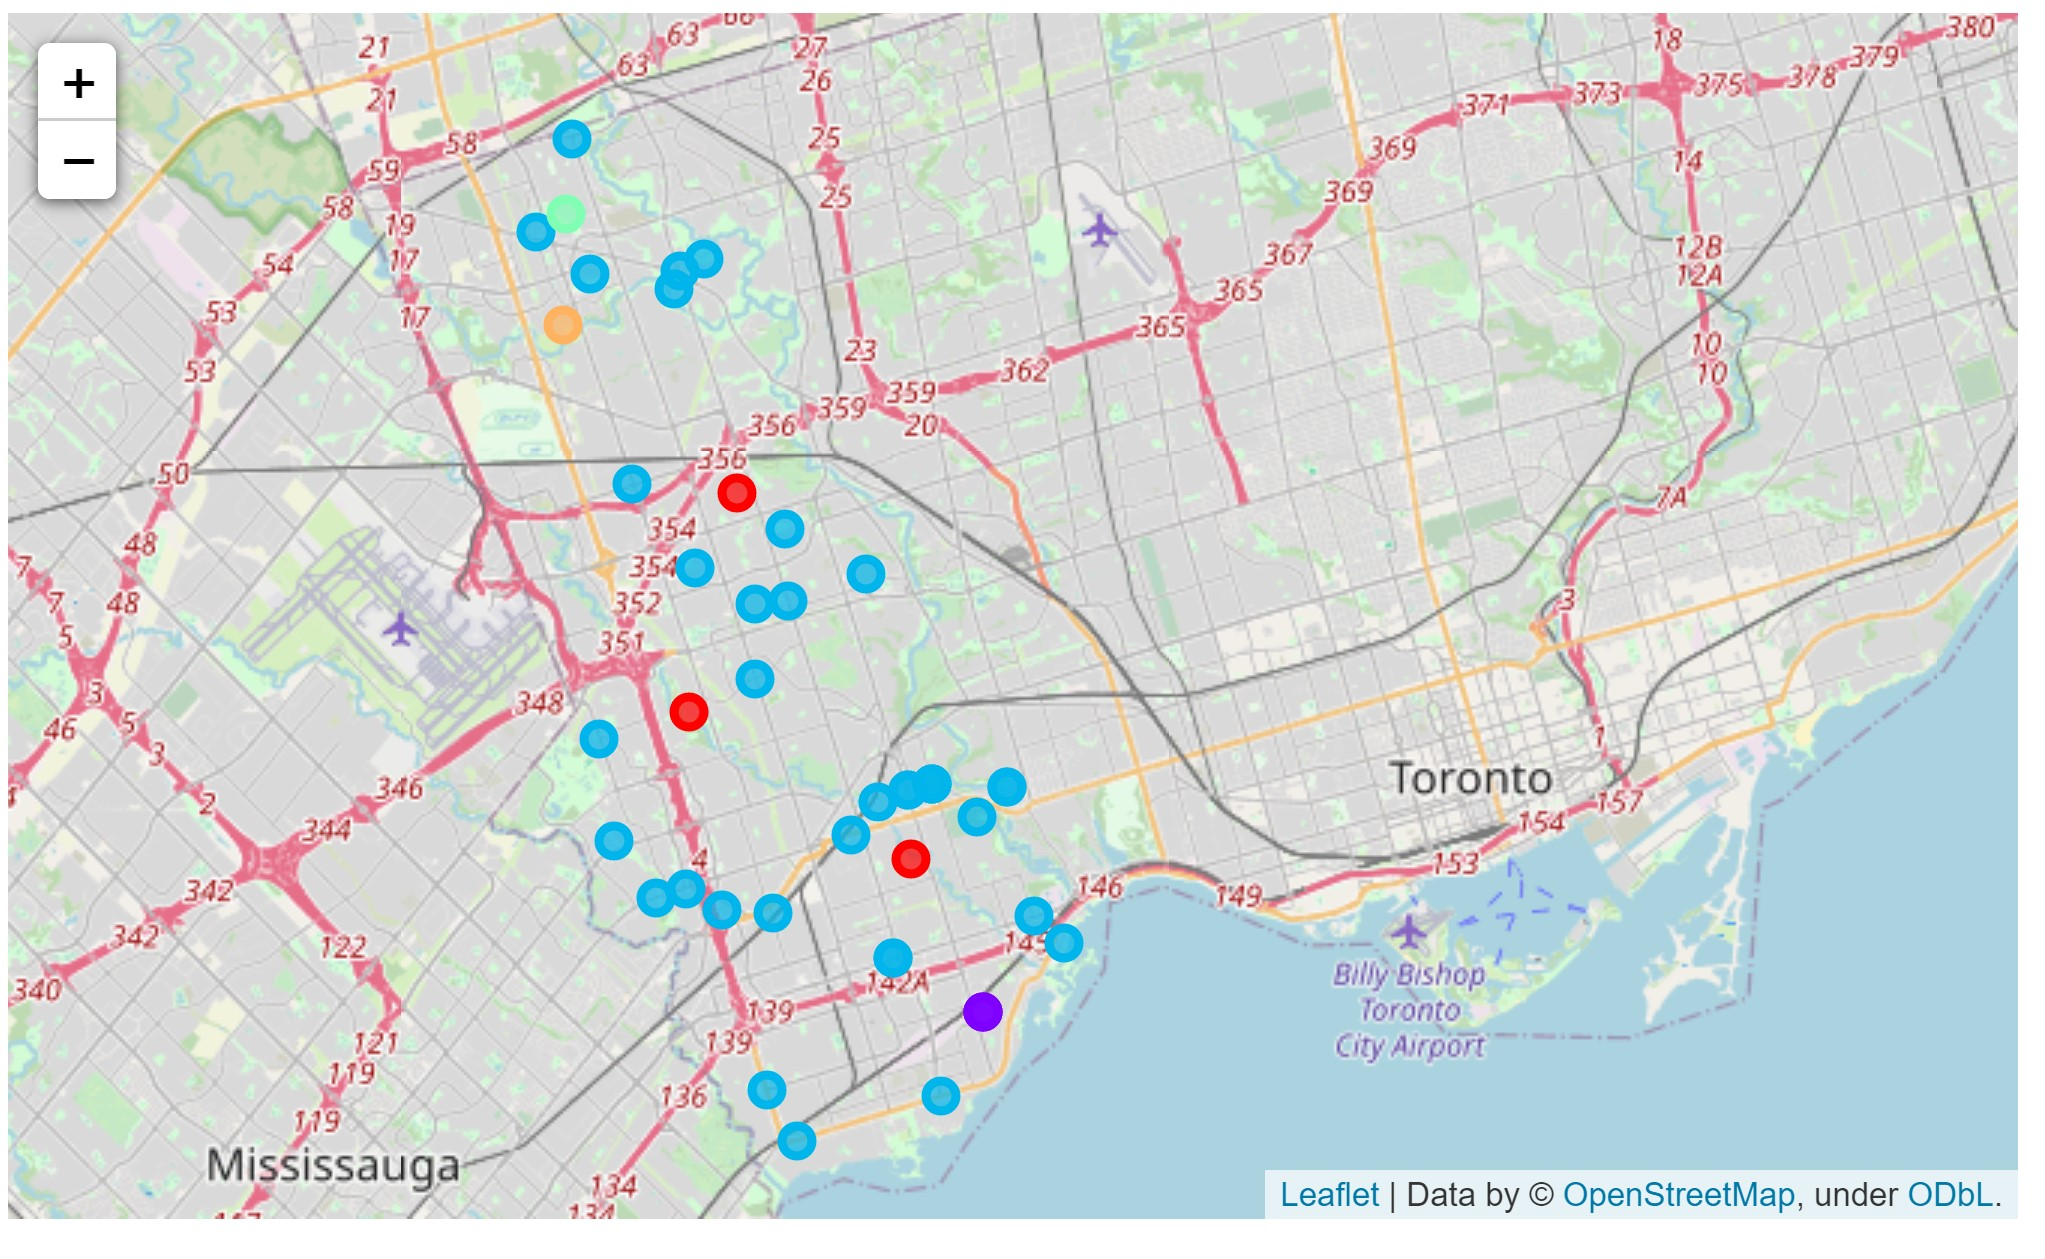


In [210]:
etobicoke_merged[(etobicoke_merged['Cluster Labels'] == 0)]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Etobicoke,West Deane Park,43.664367,-79.563172,0,Park,Convenience Store,Skating Rink,Pool Hall,Plaza,Playground,Pizza Place,Pharmacy,Pet Store,Other Great Outdoors
11,Etobicoke,Kingsview Village,43.700504,-79.551914,0,Park,American Restaurant,Hockey Arena,Pool Hall,Plaza,Playground,Pizza Place,Pharmacy,Pet Store,Other Great Outdoors
33,Etobicoke,Sunnylea,43.639945,-79.512110,0,Park,Furniture / Home Store,Other Great Outdoors,American Restaurant,Movie Theater,Plaza,Playground,Pizza Place,Pharmacy,Pet Store


In [208]:
etobicoke_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Etobicoke,Islington Avenue,43.682778,-79.540297,2,Moving Target,Intersection,Baseball Field,Park,Food Service,American Restaurant,Pool Hall,Plaza,Playground,Pizza Place
1,Etobicoke,West Deane Park,43.664367,-79.563172,0,Park,Convenience Store,Skating Rink,Pool Hall,Plaza,Playground,Pizza Place,Pharmacy,Pet Store,Other Great Outdoors
2,Etobicoke,Princess Gardens,43.670050,-79.547744,2,Construction & Landscaping,Gym / Fitness Center,Intersection,American Restaurant,Music Store,Pool Hall,Plaza,Playground,Pizza Place,Pharmacy
3,Etobicoke,Martin Grove,43.701951,-79.575692,2,Hardware Store,Intersection,Restaurant,Skating Rink,Burger Joint,Italian Restaurant,Music Store,Plaza,Playground,Pizza Place
4,Etobicoke,Islington,43.630916,-79.543484,2,Restaurant,Vietnamese Restaurant,Ice Cream Shop,Rental Car Location,Concert Hall,Fast Food Restaurant,American Restaurant,Music Store,Playground,Pizza Place


#####
### This is the end of Part 1. 